In [8]:
import os
import sys
import time
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
# Get the home directory dynamically
home_dir = os.path.expanduser("~")

# Construct the path dynamically
oft_root_path = os.path.join(home_dir, "OpenFUSIONToolkit/install_release")

# Set the environment variable
os.environ["OFT_ROOTPATH"] = oft_root_path

# Append to sys.path
tokamaker_python_path = os.getenv("OFT_ROOTPATH")
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path, "python"))


In [3]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, create_power_flux_fun
from OpenFUSIONToolkit import OFT_env


In [4]:
myOFT = OFT_env(nthreads=2)

mygs = TokaMaker(myOFT)
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('CUTE_mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.settings.lim_zmax = 0.38 # Prevent limiting in upper/lower divertor areas
mygs.setup(order=2,F0=0.17)


#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          f8ced65
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = /var/folders/z5/d2ytmy3d2h18qcqwb9v71w2m0000gq/T/oft_85042/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  1.301E+00
    # of points  =    5796
    # of edges   =   17283
    # of cells   =   11488
    # of boundary points =     102
    # of boundary edges  =     102
    # of boundary cells  =     102
  Resolution statistics:
    hmin =  3.994E-03
    hrms =  1.721E-02
    hmax =  7.410E-02
  Surface grounded at vertex     761


**** Creating Lagrange FE space
  Order  =  

{'CS01': {'id': 0, 'sub_coils': [{'reg_id': 4, 'coil_id': 0, 'nturns': 100, 'coil_set': 'CS01', 'allow_xpoints': False}]}, 'CS02': {'id': 1, 'sub_coils': [{'reg_id': 5, 'coil_id': 1, 'nturns': 100, 'coil_set': 'CS02', 'allow_xpoints': False}]}, 'CS03': {'id': 2, 'sub_coils': [{'reg_id': 6, 'coil_id': 2, 'nturns': 100, 'coil_set': 'CS03', 'allow_xpoints': False}]}, 'CS04': {'id': 3, 'sub_coils': [{'reg_id': 7, 'coil_id': 3, 'nturns': 100, 'coil_set': 'CS04', 'allow_xpoints': False}]}, 'CS05': {'id': 4, 'sub_coils': [{'reg_id': 8, 'coil_id': 4, 'nturns': 100, 'coil_set': 'CS05', 'allow_xpoints': False}]}, 'CS06': {'id': 5, 'sub_coils': [{'reg_id': 9, 'coil_id': 5, 'nturns': 100, 'coil_set': 'CS06', 'allow_xpoints': False}]}, 'CS07': {'id': 6, 'sub_coils': [{'reg_id': 10, 'coil_id': 6, 'nturns': 100, 'coil_set': 'CS07', 'allow_xpoints': False}]}, 'CS08': {'id': 7, 'sub_coils': [{'reg_id': 11, 'coil_id': 7, 'nturns': 100, 'coil_set': 'CS08', 'allow_xpoints': False}]}, 'CS09': {'id': 8, 'su

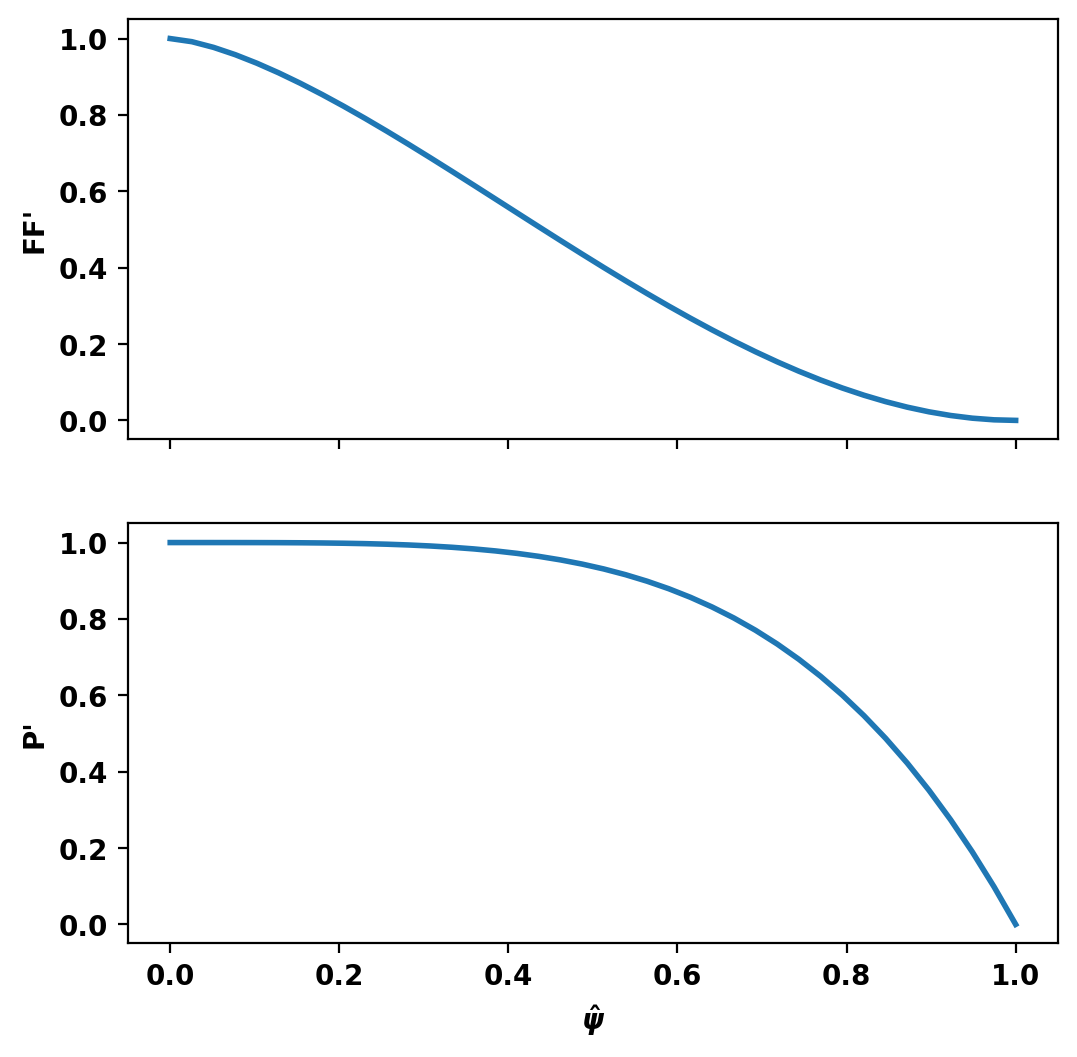

In [5]:
## Set "hard" limits on coil currents
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds = {key: [-1.E3, 1.E3] for key in mygs.coil_sets}
coil_mirrors = {'CS{0:02d}'.format(2*i+1): 'CS{0:02d}'.format(2*i+2) for i in range(7)}
coil_mirrors.update({'PF{0:02d}'.format(i): 'PF{0:02d}'.format(15-i) for i in range(1,8)})
## Regularization matrix for coils
coil_regmat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
coil_reg_weights = np.zeros((mygs.ncoils+1,), dtype=np.float64)
disable_list = ['PF01','PF14']
print(mygs.coil_sets)
for name, coil in mygs.coil_sets.items():
    if name not in coil_mirrors:
        continue
    coil_regmat[coil['id'],coil['id']] = 1.0
    coil_reg_weights[coil['id']] = 1.E-2
    mirror_coil = mygs.coil_sets[coil_mirrors[name]]
    coil_regmat[mirror_coil['id'],[coil['id'],mirror_coil['id']]] = [1.0,-1.0]
    coil_reg_weights[mirror_coil['id']] = 1.E-1
    if name in disable_list:
        coil_reg_weights[coil['id']] = 1.E4
        coil_regmat[mirror_coil['id'],[coil['id'],mirror_coil['id']]] = [0.0,1.0]
        coil_reg_weights[mirror_coil['id']] = 1.E4
# Vertical stability coil (not specified so ignored)
coil_regmat[mygs.ncoils,mygs.ncoils] = 1.0
coil_reg_weights[mygs.ncoils] = 1.E5
coil_reg_weights *= 10.0
mygs.set_coil_reg(coil_regmat,reg_weights=coil_reg_weights)

# Set profiles
ffp_prof = create_power_flux_fun(40,1.5,2.0)
pp_prof = create_power_flux_fun(40,4.0,1.0)

fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

In [6]:
Ip_target = 200.E3
mygs.set_targets(Ip=Ip_target,Ip_ratio=1.0)

isoflux_pts = create_isoflux(80,0.32,0.0,0.17,1.7,0.4)
# Trim isoflux constraints to outboard side only
isoflux_pts = isoflux_pts[isoflux_pts[:,0]>0.3,:]
# Add a single inboard point back in
isoflux_pts = np.vstack((isoflux_pts,np.array([[0.15,0.0],])))
# Define X-points
x_points = np.array([
    [0.22,-0.33],
    [0.20,0.34]
])
mygs.set_saddles(x_points)
mygs.set_isoflux(np.vstack((isoflux_pts,x_points[0,:])))

In [11]:
beta_approx = 0.2
mygs.set_targets(Ip=Ip_target,Ip_ratio=(1.0/beta_approx - 1.0))
mygs.set_saddles(x_points)
mygs.set_isoflux(np.vstack((isoflux_pts,x_points)))
mygs.init_psi(0.32,0.0,0.13,1.7,0.4)
err_flag = mygs.solve()

Starting non-linear GS solver
     1  2.3289E+00  1.4875E+00  6.3391E-03  3.4320E-01  7.3704E-04 -1.8546E-22
     2  2.5451E+00  1.5358E+00  1.4525E-03  3.4134E-01  7.1572E-04 -5.4306E-24
     3  2.6170E+00  1.5572E+00  4.1092E-04  3.4050E-01  6.9276E-04  5.0249E-22
     4  2.6494E+00  1.5676E+00  1.4801E-04  3.4011E-01  6.7451E-04  2.5402E-21
     5  2.6649E+00  1.5728E+00  6.2491E-05  3.3992E-01  6.6017E-04 -1.1187E-21
     6  2.6725E+00  1.5753E+00  2.8539E-05  3.3983E-01  6.4897E-04  1.7891E-21
     7  2.6763E+00  1.5765E+00  1.3565E-05  3.3979E-01  6.4034E-04  8.7481E-22
     8  2.6782E+00  1.5771E+00  6.6502E-06  3.3977E-01  6.3376E-04 -1.2262E-21
     9  2.6792E+00  1.5775E+00  3.4125E-06  3.3976E-01  6.2878E-04  1.1194E-21
    10  2.6797E+00  1.5776E+00  1.8961E-06  3.3976E-01  6.2504E-04  7.9270E-22
    11  2.6800E+00  1.5777E+00  1.1724E-06  3.3976E-01  6.2225E-04  5.3582E-22
    12  2.6802E+00  1.5777E+00  7.9698E-07  3.3976E-01  6.2018E-04 -9.6516E-22
 Timing:  0.1341780000

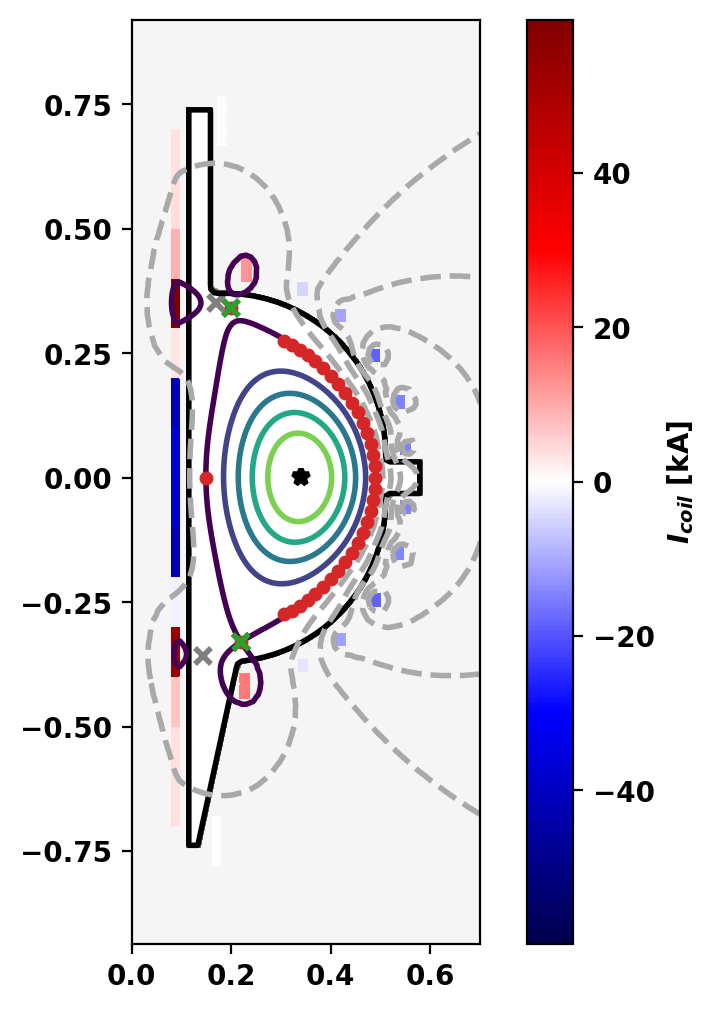

In [12]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.0E-3,coil_clabel=r'$I_{coil}$ [kA]')
mygs.plot_psi(fig,ax,xpoint_color='k',vacuum_nlevels=6,plasma_nlevels=6)
mygs.plot_constraints(fig,ax,isoflux_color='tab:red',isoflux_marker='.')

In [13]:
psi0 = mygs.get_psi(False)
# Compute linear stability
eig_vals, eig_vecs = mygs.eig_td(-1.E5,10,False)
eig_sign = eig_vecs[0,mygs.r[:,1]>0.0][abs(eig_vecs[0,mygs.r[:,1]>0.0]).argmax()]

In [14]:
psi_ic = psi0-0.01*eig_vecs[0,:]*(mygs.psi_bounds[1]-mygs.psi_bounds[0])/eig_sign
mygs.set_psi(psi_ic)
mygs.set_saddles(None)
mygs.set_isoflux(None)
dt = 0.2/abs(eig_vals[0,0])
mygs.setup_td(dt,1.E-13,1.E-11)
sim_time = 0.0
results = []
z0 = [[sim_time,mygs.o_point[1]],]
for i in range(30):
    sim_time, _, nl_its, lin_its, nretry = mygs.step_td(sim_time,dt)
    assert nretry >= 0
    z0.append([sim_time,mygs.o_point[1]])
    results.append(mygs.get_psi())

Starting Newton solver
     0  6.126647E-01  5.377789E-10  8.777703E-10
Starting GMRES solver
     0  0.000000E+00  5.377789E-10
     1                5.325847E-11
     2                2.195324E-11
     3                1.355614E-11
     4                8.219171E-12
     5                3.624107E-12
     6                4.929532E-13
     7  2.266430E-03  5.041449E-13  2.224401E-10
     1  6.139098E-01  1.190289E-12  1.938867E-12
  Timing:
    Metric =   9.231E-03
    Update =   4.270E-03
    Invert =   1.075E-01
Starting Newton solver
     0  6.139098E-01  6.795122E-10  1.106860E-09
Starting GMRES solver
     0  0.000000E+00  6.795122E-10
     1                2.899642E-11
     2                2.176208E-11
     3                1.180097E-11
     4                4.269925E-12
     5                1.167914E-12
     6                1.908659E-13
     7  2.004569E-03  2.887870E-13  1.440643E-10
     1  6.142609E-01  8.417882E-13  1.370408E-12
  Timing:
    Metric =   9.396E-03
    Up

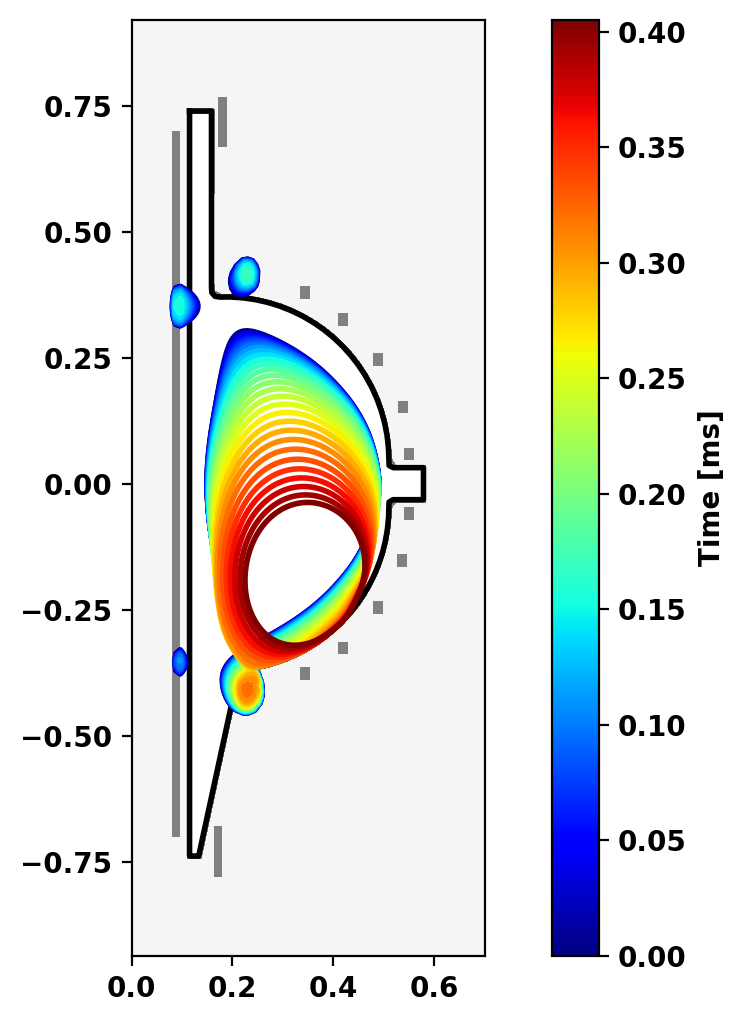

In [15]:
import matplotlib as mpl
fig, ax = plt.subplots(constrained_layout=True,figsize=(8,5))
mygs.plot_machine(fig,ax)
colors = plt.cm.jet(np.linspace(0,1,len(results)))
for i, result in enumerate(results):
    mygs.plot_psi(fig,ax,psi=result,plasma_nlevels=1,plasma_color=[colors[i]], vacuum_nlevels = 0,xpoint_color=None,opoint_color=None)
norm = mpl.colors.Normalize(vmin=0.0, vmax=sim_time*1.E3)
colors = plt.cm.jet(np.linspace(0,1,len(results)))

norm = mpl.colors.Normalize(vmin=0.0, vmax=sim_time*1.E3)
_ = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet),ax=ax,label='Time [ms]')


In [16]:
import matplotlib.animation
from matplotlib.ticker import FuncFormatter
from IPython.display import HTML
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['animation.embed_limit'] = 1.E8

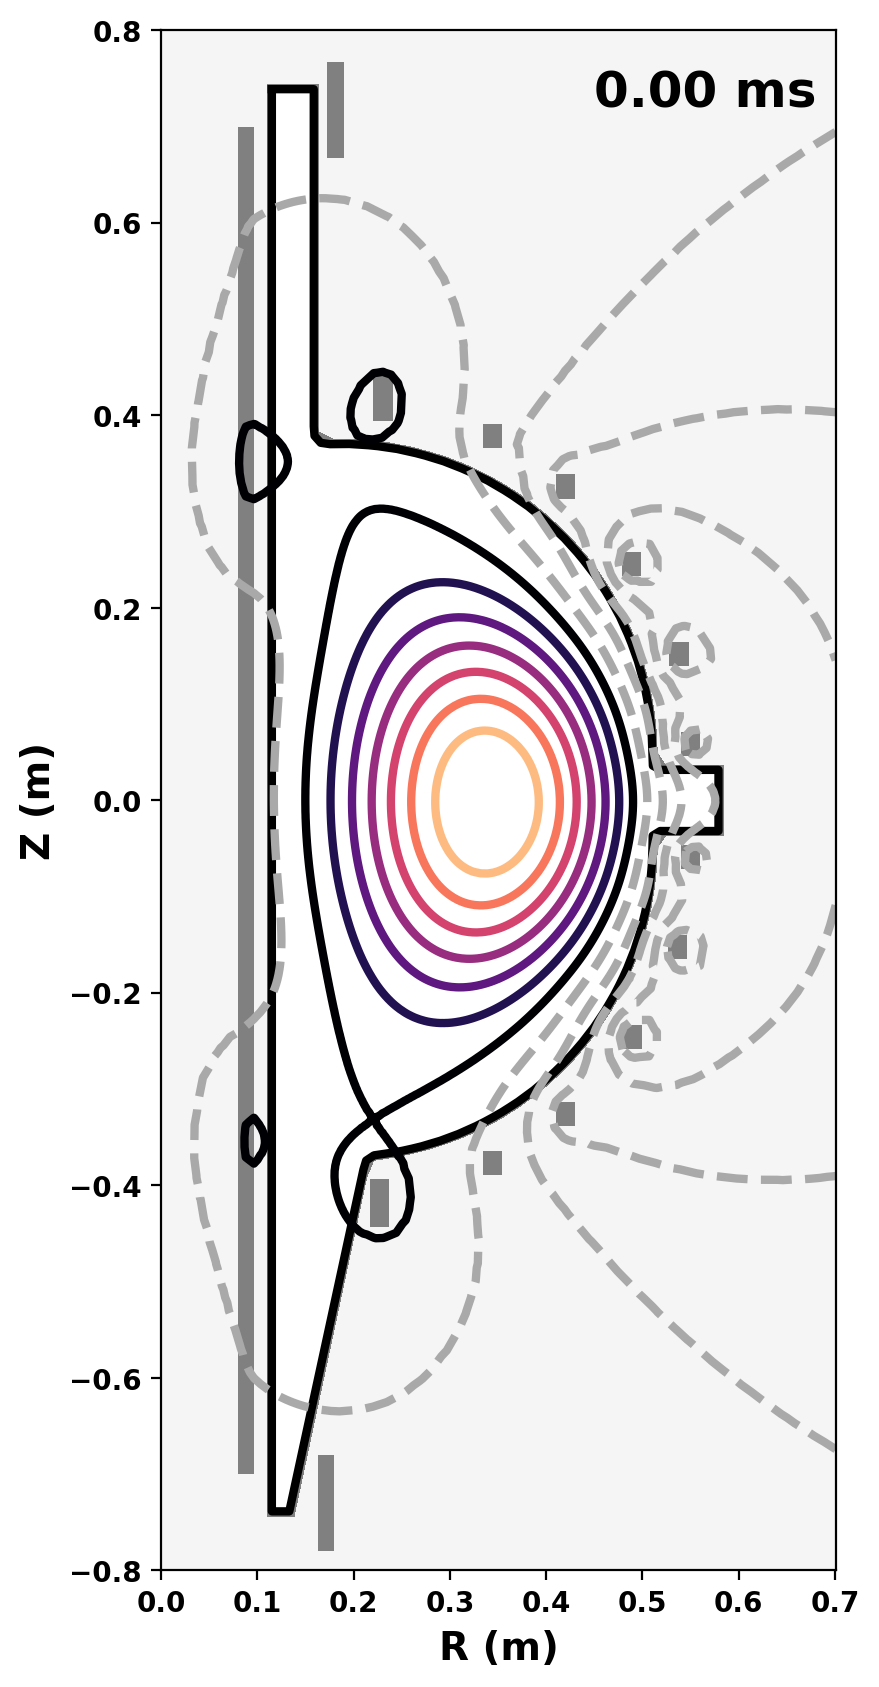

In [17]:
plt.rcParams['lines.linewidth']=3
fig, ax = plt.subplots(figsize=(16,10))
times = np.linspace(0,sim_time, len(results))*1000
def animate(i):
    ax.clear()
    mygs.plot_machine(fig,ax)
    mygs.plot_psi(fig,ax,psi=results[i],plasma_nlevels=8,plasma_colormap= 'magma', vacuum_nlevels = 6,xpoint_color=None,opoint_color=None)
    ax.text(0.45, 0.72, f"{times[i]:.2f}"+' ms', color = 'k', fontsize = 18)
    ax.set_xlabel('R (m)', fontsize = 14)
    ax.set_ylabel('Z (m)', fontsize = 14)
    ax.set_ylim(-0.8, 0.8)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(results))

''
HTML(ani.to_jshtml())

# Save as GIF
writer = matplotlib.animation.PillowWriter(fps=5,
                                 metadata=dict(artist='Sophia Guizzo'),
                                 bitrate=1800)
ani.save('cute_vde.gif', writer=writer)